## Assignment 5
Max Norton  
ECON 628

In [414]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLecturePackages", tag="v0.3.1");

In [415]:
using LinearAlgebra, Statistics, Compat

### Exercise 1

In [416]:
function findS(A, Σ; S₀=ones(Int(round(length(A)/ndims(A))), Int(round(length(A)/ndims(A)))), tol=1E-6, maxiter=1000)
    iter = 0
    S_old = S₀
    S_new = A*S_old*A' + Σ*Σ'
    while norm(S_old - S_new) > tol && iter<maxiter
        iter += 1
        S_old = S_new
        S_new = A*S_old*A' + Σ*Σ'
    end
    return (S = S_new, iter=iter)
end

A_arg = [0.8 -0.2; -0.1 0.7]
Σ = [0.5 0.4; 0.4 0.6]
@show findS(A_arg, Σ)

findS(A_arg, Σ) = (S = [0.671228 0.633476; 0.633476 0.858874], iter = 49)


(S = [0.671228 0.633476; 0.633476 0.858874], iter = 49)

In [417]:
using QuantEcon

In [418]:
solve_discrete_lyapunov(A_arg, Σ*Σ', 1000)

2×2 Array{Float64,2}:
 0.671231  0.633474
 0.633474  0.858874

In [419]:
norm(findS(A_arg, Σ).S - solve_discrete_lyapunov(A_arg, Σ*Σ'))


3.883245447999784e-6

### Exercise 2

In [420]:
function genseries(θ, T; γ=1, σ=1, y₀=0.0)
    ser = fill(y₀, T)
    for t in 2:T
        w = randn()
        ser[t] = γ + θ*ser[t-1] + σ*w
    end
    return ser
end

function rollingmean(y)
    mean = similar(y)
    for i in 2:length(y) # could drop 2: but then it recalculates the first entry as y
        mean(i) = sum(y[1:i])/i 
    end
    return mean
end

rollingmean (generic function with 1 method)

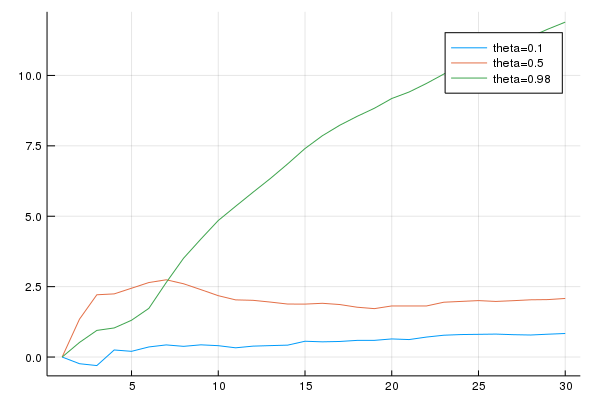

In [421]:
using Plots
gr(fmt=:png)

Θ=(0.1, 0.5, 0.98)
T=30

plot(1:T, rollingmean(genseries(Θ[1], 30)), label="theta=$(Θ[1])")
plot!(1:T, rollingmean(genseries(Θ[2], 30)), label="theta=$(Θ[2])")
plot!(1:T, rollingmean(genseries(Θ[3], 30)), label="theta=$(Θ[3])")
# Q: How do I broadcast the plot across all three series rather than calling plot, plot!, plot!? 

Note: var() does a sample-variance correction, so its output does not match the formula given for variance.
var(yT1) == sum(yT1 .^ 2 / length(yT1)) - sum(yT1 / length(yT1)) ^ 2 = false
var(yT1) == sum((yT1 .- mean(yT1)) .^ 2) / (length(yT1) - 1) = true
To make the code nicer, my figure labels report variance as calculated by var().


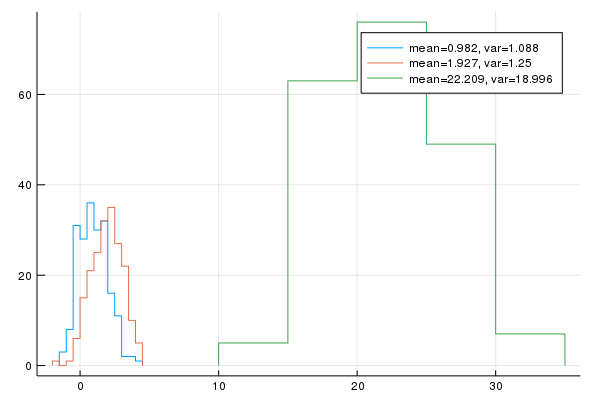

In [422]:
using Parameters

function simulateseries(params, n)
    @unpack θ, T, γ, σ, y₀ = params
    simulations = [genseries(θ, T, γ=γ, σ=σ, y₀=y₀) for _ in 1:n]
end        

paramgen = @with_kw (θ, T=30, γ=1, σ=1, y₀=0.0)

N=200

yTinstance = zeros(N)
yT = fill(yTinstance, 3)
label = fill("", 3)

for (i, θ) in enumerate(Θ)
    sims = simulateseries( paramgen(θ=θ), N )
    yT[i] = [sim[end] for sim in sims]
    label[i] = "mean=$(round(mean(yT[i]), digits=3)), var=$(round(var(yT[i]), digits=3))"
end

#@show mean(yT1)
println("Note: var() does a sample-variance correction, so its output does not match the formula given for variance.")
@show var(yT1)==sum(yT1.^2/length(yT1)) - sum(yT1/length(yT1))^2
@show var(yT1)==sum((yT1 .- mean(yT1)).^2) / (length(yT1)-1)
println("To make the code nicer, my figure labels report variance as calculated by var().")

stephist(yT[1], label=label[1])
stephist!(yT[2], label=label[2])
stephist!(yT[3], label=label[3])

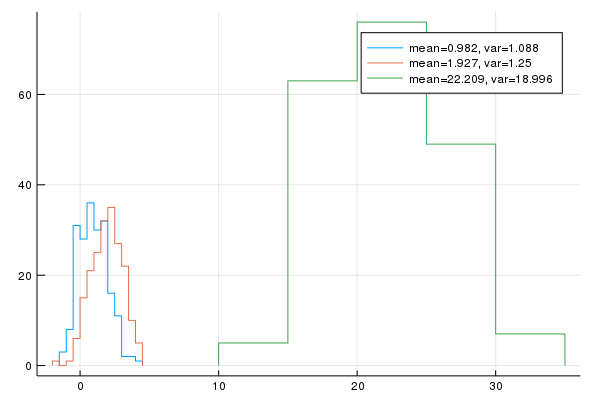

In [423]:
# Above I was trying to broadcast plot() and couldn't get it to work. However, passing an array to stephist() appears to work, because the code below generates the exact same hist:

stephist(yT[1:3], label=label[1:3])

# Suggests the following answer for simplifying my plot calls: 
# 1. build out each rollingmean series
# 2. save them all in a single array (of arrays)
# 3. save some labels in an array
# 4. pass those arrays to plot

### Exercise 3 

In [424]:
N=50
M=20
params = (a=0.1, b=0.2, c=0.5, d=1.0, σ=0.1)

x1 = randn(N)
x2 = randn(N)

# some simple helper functions
dgp(x1, x2, a, b, c, d)  = a*x1 .+ b*x1.^2 .+ c*x2 .+ d
olscoeff(y, x) = (x'*x)\(x'*y)

function simulatey(x1, x2, params) # simulate N observations of y
    w = randn(N)
    @unpack a, b, c, d, σ = params
    dgp(x1, x2, a, b, c, d) + σ.*w
end

function repeatsims(M, x1, x2, params) # generate M sets of N observations on (Y, X)
    sims = fill(zeros(N), M)
    for i in 1:M
        sims[i]=simulatey(x1, x2, params)
    end
    return sims
end

function getestimates(y, z) # estimate coefficients for each independent variable 
    estimate = z'z\z'y
    push!(estimate, eststdev(y, z, estimate))
    return estimate
end    

function eststdev(y, z, est) # estimate σ based on observed y and coefficient estimates
    a = est[1]; b=est[2]; c=est[3]; d=est[4] #how to do this in a more generic fashion?
    err = y .- dgp(z[:,1], z[:,3], a, b, c, d)
    return sqrt(var(err)) 
end

exes = hcat(x1, x1.^2, x2, ones(N))
sims = repeatsims(M, x1, x2, params)
getestimates(sims[1][:], exes)

5-element Array{Float64,1}:
 0.09634509968179172
 0.17587610598266226
 0.4926236782969783 
 1.0178086501779238 
 0.10219595205216589

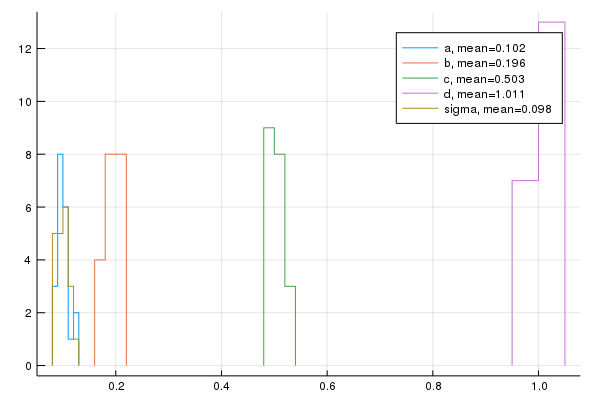

In [425]:
estimates=zeros(5,M)
for i in 1:M
    estimates[:,i] = getestimates(sims[i][:], exes)
end

stephist(estimates[1,:], label="a, mean=$(round(mean(estimates[1,:]), digits=3))")
stephist!(estimates[2,:], label="b, mean=$(round(mean(estimates[2,:]), digits=3))")
stephist!(estimates[3,:], label="c, mean=$(round(mean(estimates[3,:]), digits=3))")
stephist!(estimates[4,:], label="d, mean=$(round(mean(estimates[4,:]), digits=3))")
stephist!(estimates[5,:], label="sigma, mean=$(round(mean(estimates[5,:]), digits=3))")

It seems like there could be a more stylish way to store the estimates than a giant unlabelled matrix; perhaps output a tuple from getestimates(), create independent arrays for each parameter, and plot/take means over each array separately. But I already dislike how specifically my eststdev function is linked to the functional form of the dgp, and naming a tuple that getestimates() returns would similarly degeneralize that function. With more time to think it through, could probably untangle this and find a more elegant solution.

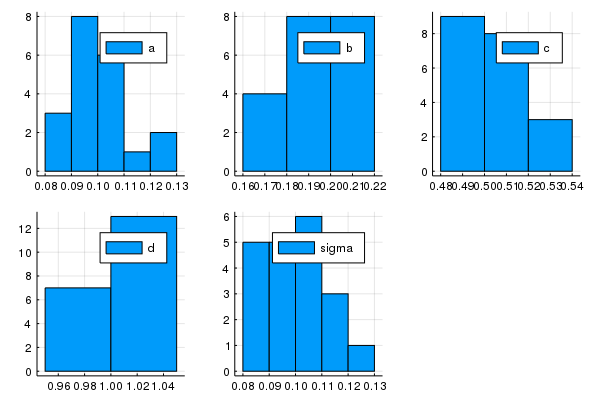

In [426]:
histogram(estimates', layout=5, label=["a" "b" "c" "d" "sigma"])